<a href="https://colab.research.google.com/github/dheerajmr01/transformer_v1/blob/main/transformer_mybuild.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax,pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


RUN_EXAMPLES = True
print(torch.__version__)


2.6.0+cu124


#Helper functions:

In [34]:
def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None

class DummyScheduler:
    def step(self):
        None

# This is the main model class:

In [3]:
class EncoderDecoder(nn.Module):

  """
    Main Architecture of the encoder and decoder
  """

  def __init__(self, encoder, decoder, source_embeddings, target_embeddings, generator):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.generator = generator
    self.source_embeddings = source_embeddings
    self.target_embeddings = target_embeddings

  def forward(self, src, tgt, src_mask, tgt_mask):
      "Take in and process masked src and target sequences."
      return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, source, source_mask):
    return self.encoder(self.source_embeddings(source),source_mask)

  def decode(self, memory, source_mask, target, target_mask):
    return self.decoder(self.target_embeddings(target), memory, source_mask, target_mask)

# Now we build the encoder, decoder, self-attention, generator, embedding classes.

In [4]:
class Generator(nn.Module):
  def __init__(self, d_model, vocab) -> None:
     super().__init__()
     self.projections = nn.Linear(d_model, vocab)

  def forward(self,x):
    return log_softmax(self.projections(x), dim=1)

#Helper Layers

In [5]:
def clones(module, N):
  """
  Duplicating layers

  """
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [7]:
class LayerNorm(nn.Module):
    "Construct a layernorm module as per paperand standards for reducing training time "

    def __init__(self, features, eps = 1e-6):
      super().__init__()
      self.a_2 = nn.Parameter(torch.ones(features))
      self.b_2 = nn.Parameter(torch.zeros(features))
      self.eps = eps

    def forward(self, x):
      mean = x.mean(-1, keepdim=True)
      std = x.std(-1, keepdim=True)
      return self.a_2 * (x - mean)/ (std + self.eps) + self.b_2


In [8]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

#Encoder Layer


In [9]:
class EncoderLayer(nn.Module):
  "Self attention layer and feed forward Layer"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super().__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self,x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)


In [6]:
class Encoder(nn.Module):
  "Stack of N layers"

  def __init__(self, layer, N):
    super().__init__()
    self.layers = clones(layer,N) # EncoderLayer will be the layer input.
    self.norm = LayerNorm(layer.size)

  def forward(self,x, mask):
    "pass the input and mask thu each layer"
    for layer in self.layers:
      x  = layer(x,mask)
    return self.norm(x)

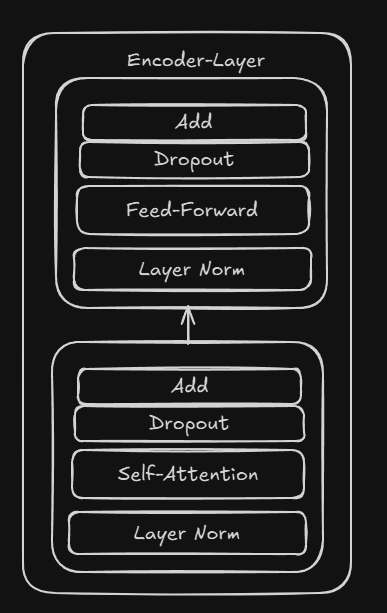

#Decoder Layer

In [10]:
class Decoder(nn.Module):
  "N layer Decoder"
  def __init__(self,layer, N):
    super().__init__()
    self.layers = clones(layer,N)
    self.norm = LayerNorm(layer.size)

  def forward(self,x, memory, source_mask, target_mask):
    for layer in self.layers:
      x = layer(x, memory, source_mask, target_mask)
    return self.norm(x)

In [11]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [21]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

# Attention mechanism:
Here i implement standard attention mechanism which is a scaled dot product attention.

In [19]:
def attention(query, key, value, mask=None, dropout=None):
  """Computing the scaled dot product"""
  dim_k = query.size(-1)
  scores = query @ key.transpose(-2,-1) / math.sqrt(dim_k)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = scores.softmax(dim=-1)
  if dropout is not None:
    p_attn = dropout(p_attn)
  return p_attn @ value , p_attn

In [12]:
#from re import X
class MultiHeadedAttention(nn.Module):
  def __init__(self, h, dim_model, dropout=0.1):
    "Take in model size and number of heads."
    super().__init__()
    assert dim_model % h == 0
    # Assume dim of value and key are same
    self.dim_k = dim_model // h
    self.h = h
    self.linears = clones(nn.Linear(dim_model, dim_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)

  def forward(self,query, key, value, mask = None):
    if mask is not None:
      mask = mask.unsqueeze(1)

    nbatches = query.size(0)

    query, key, value = [lin(x).view(nbatches, -1, self.h, self.dim_k).transpose(1,2) for lin, x in zip(self.linears,(query, key, value))]

    # Applying attention on all the projected vectors in batch
    x, self.attn = attention(query, key, value, mask=mask, dropout = self.dropout)

    # Concat using view and applying final linear
    x = (x.transpose(1,2).contiguous().view(nbatches,-1, self.h * self.dim_k))

    del query
    del key
    del value
    return self.linears[-1](x)


# Embeddings and positional encoding


In [13]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, dim_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(dim_model, d_ff)
        self.w_2 = nn.Linear(d_ff, dim_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [14]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [15]:
class PositionalEncoding(nn.Module):
    "Implementing the PE function using sin and cos waves."

    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

# Model:

In [16]:
def build_model(source_vocab, target_vocab, N=6, dim_model=512, dim_feed_forward=2048, h=8, dropout=0.1):
  """Constructing a model with the given parameters"""

  c = copy.deepcopy
  attn = MultiHeadedAttention(h,dim_model)
  ff = PositionwiseFeedForward(dim_model, dim_feed_forward, dropout)
  position = PositionalEncoding(dim_model, dropout)

  model = EncoderDecoder(
      Encoder(EncoderLayer(dim_model, c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(dim_model, c(attn), c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(dim_model, source_vocab), c(position)),
      nn.Sequential(Embeddings(dim_model, target_vocab), c(position)),
      Generator(dim_model, target_vocab)
  )

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)
  return model

# Inferencing without training the transformer model

In [17]:
def inference_test():
  test_model = build_model(11,11,2)
  test_model.eval()
  source = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
  source_mask = torch.ones(1,1,10)

  memory = test_model.encode(source,source_mask)
  ys = torch.zeros(1,1).type_as(source)


  for i in range(9):
    out = test_model.decode(
        memory,source_mask, ys, subsequent_mask(ys.size(1)).type_as(source.data)
        )

    prob = test_model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data[0]
    ys = torch.cat(
        [ys, torch.empty(1,1).type_as(source.data).fill_(next_word)], dim=1
    )

  print("Untrained model predictions: ", ys)


In [22]:
def run_tests():
  for _ in range(10):
    inference_test()

show_example(run_tests)

Untrained model predictions:  tensor([[ 0,  4, 10,  6,  6,  6,  6,  6,  6,  6]])
Untrained model predictions:  tensor([[ 0,  9,  9,  9,  9,  9,  9, 10,  0,  9]])
Untrained model predictions:  tensor([[0, 3, 4, 5, 0, 5, 0, 5, 0, 5]])
Untrained model predictions:  tensor([[0, 9, 1, 9, 1, 9, 1, 9, 1, 9]])
Untrained model predictions:  tensor([[0, 6, 1, 6, 1, 6, 1, 6, 1, 6]])
Untrained model predictions:  tensor([[ 0,  9,  0,  9,  0,  9, 10,  5,  5,  5]])
Untrained model predictions:  tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])
Untrained model predictions:  tensor([[ 0, 10,  8,  5,  5,  5,  5,  5,  8,  0]])
Untrained model predictions:  tensor([[0, 4, 4, 4, 4, 7, 7, 2, 2, 8]])
Untrained model predictions:  tensor([[ 0,  3,  3,  7,  1,  6,  6, 10,  3,  3]])


#Model Training

Batches and Masking

In [23]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

#Loss Computation:

In [24]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        )
        return sloss.data * norm, sloss

Training Loop

In [25]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [26]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

Optimizer: Adam

implementing a increasing the learning rate linearly for the first warmup_steps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.

In [27]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

Label Smoothing

This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.



In [28]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

# Example of training with Synthetic Data

In [29]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

Decoding : predicts a translation using greedy decoding for simplicity.

In [30]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

Training the model on this data

In [35]:
def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = build_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.source_embeddings[0].d_model, factor=1.0, warmup=400 # Changed src_embeddings to source_embeddings
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))

In [36]:
execute_example(example_simple_model)

Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.62 | Tokens / Sec:   470.0 | Learning Rate: 5.5e-06
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.18 | Tokens / Sec:   478.6 | Learning Rate: 6.1e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.98 | Tokens / Sec:   413.2 | Learning Rate: 1.2e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.83 | Tokens / Sec:   473.3 | Learning Rate: 1.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.62 | Tokens / Sec:   490.8 | Learning Rate: 2.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.36 | Tokens / Sec:   433.4 | Learning Rate: 2.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.20 | Tokens / Sec:   478.5 | Learning Rate: 3.4e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.08 | Tokens / Sec:   490.2 | Learning Rate: 3.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.86 | Tokens / Sec:   416.1 | Learning Rate: 4.5e-04
Epoch Step:      1 | Accumul